# CSE483 Computer Vision Project (Spring 2023)
# Final Submission

# Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

!pip install --upgrade reedsolo
import reedsolo as rs
!pip install --upgrade galois
import galois

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 22.6 MB/s eta 0:00:00


In [2]:
!git clone 'https://github.com/Ahmed-T-Taha/QR-Code-Reader'
test_cases = []
import os
test_cases_path = '/content/QR-Code-Reader/Test-Cases/'
for img_name in os.listdir(test_cases_path) :
  test_cases.append(cv2.imread(test_cases_path + img_name))

Cloning into 'QR-Code-Reader'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 2.13 MiB | 22.47 MiB/s, done.


# Color Correction

In [3]:
def color_correct(img):
  # Make all non-grayscale pixels white as they will not be part of the qr code
  for i, row in enumerate(img):
    for j, pixel in enumerate(row):
      pixel = [int(p) for p in pixel]
      if any((abs(pixel[0] - pixel[1]) > 10,
             abs(pixel[0] - pixel[2]) > 10,
             abs(pixel[1] - pixel[2]) > 10)):
        img[i][j] = (255, 255, 255)

  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  _, img_thresh = cv2.threshold(img_gray, np.mean(img_gray), 255, cv2.THRESH_BINARY)

  # If more than 99% of border pixels are black, the image is most likely color-inverted
  black = 0
  borders = np.concatenate((img_thresh[0], img_thresh[-1],
                            cv2.transpose(img_thresh)[0], cv2.transpose(img_thresh)[-1]))
  for pixel in borders:
    if pixel == 0:
      black += 1

  if black > 0.99 * len(borders):
    img_gray = cv2.cvtColor(255 - img, cv2.COLOR_BGR2GRAY)

  #img_equalized = cv2.equalizeHist(img_gray)
  return img_gray

# Periodic Noise Removal

In [4]:
def remove_periodic_noise(img):
  # get the frequency domain
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)

  # Remove the outlier frequencies
  fshift_abs = abs(fshift)
  fshift_med20 = 20 * cv2.medianBlur(fshift_abs.astype('float32'), 5)
  for i, row in enumerate(fshift_abs):
    for j, point in enumerate(row):
      if point > fshift_med20[i, j]:
        fshift[i, j] = fshift_med20[i, j] / 20

  # get the spatial domain back
  f_ishift = np.fft.ifftshift(fshift)
  img_back = np.fft.ifft2(f_ishift)
  img_back = np.real(img_back)
  img_back_normal = cv2.normalize(img_back, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8UC1)
  return img_back_normal

# Warp & Get Box Containing Image

In [5]:
def straighten(img):
  # Find the convex hull of the image
  # The operation is done on a color-inverted version
  _, img_thresh = cv2.threshold(img, np.mean(img), 255, cv2.THRESH_BINARY)
  img_reverse = 255 - img_thresh
  contours, _ = cv2.findContours(img_reverse, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  cnts = np.concatenate(contours)
  hull = cv2.convexHull(cnts)

  # Approximate the convex hull to a polygon
  def closest_point (points_list, p):
    return min(points_list, key=lambda x: ((x[0]-p[0])**2 + (x[1]-p[1])**2))
  corners = cv2.approxPolyDP(hull, 0.02* cv2.arcLength(hull, True), True)
  corners = [p[0] for p in corners]


  # Find the points in the convex hull closest to each of the 4 corners
  rows, cols = img_thresh.shape
  top_left = closest_point(corners, [0, 0])
  top_right = closest_point(corners, [cols - 1, 0])
  bottom_left = closest_point(corners, [0, rows - 1])
  bottom_right = closest_point(corners, [cols - 1, rows - 1])

  # Find vectors of each of the 4 lines
  top_line = top_left - top_right
  left_line = top_left - bottom_left
  bottom_line = bottom_right - bottom_left
  right_line = bottom_right - top_right

  # Find angles at each of the 4 corners
  def find_angle(line1, line2):
    num = np.dot(line1, line2)
    denom = np.linalg.norm(line1) * np.linalg.norm(line2)
    angle = np.arccos(num/denom) * 180 / np.pi
    return angle

  # If the angle is sufficiently close to 90, warpAffine is not necessary
  if any((abs(find_angle(top_line, left_line) - 90) < 5,
         abs(find_angle(top_line, right_line) - 90) < 5,
         abs(find_angle(bottom_line, left_line) - 90) < 5,
         abs(find_angle(bottom_line, right_line) - 90) < 5)):
    # Here we will get the bounding box for the image
    # We try to pad with 10 pixels if possible to allow quiet zone
    x,y,w,h = cv2.boundingRect(hull)
    left_bound = max(0, x-10)
    right_bound = min(cols - 1, x+h+10)
    top_bound = max(0, y-10)
    bottom_bound = min(rows - 1, y+h+10)
    return img[top_bound : bottom_bound , left_bound : right_bound]


  # If we reached this point, then image needs to be warped
  # Perform affine warp using the points we got to straighten the image
  srcTri = np.array([top_left, top_right, bottom_right]).astype(np.float32)
  dstTri = np.array([[10, 10], [cols - 11, 10], [cols - 11, rows - 11]]).astype(np.float32)
  warp_mat = cv2.getAffineTransform(srcTri, dstTri)
  img_warp = cv2.warpAffine(img, warp_mat, (cols, rows), borderMode=cv2.BORDER_REPLICATE)
  return img_warp

# Pre-Processing

In [6]:
def pre_process(img):
  # Remove colored pixels and convert to grayscale
  img_gray = color_correct(img)

  # Remove periodic noise
  img_noise_removed = remove_periodic_noise(img_gray)

  # Straighten image if warped, and return image inside bounding box
  img_straightened = straighten(img_noise_removed)

  # Resize image to standardize masks to be applied
  img_resized = cv2.resize(img_straightened, (1024, 1024))

  # Apply median blur, but only use it moving forward if it results in a major change
  img_median = cv2.medianBlur(img_resized, 21)
  if np.mean(abs(img_resized - img_median)) > 85:
    img_resized = img_median

  # Apply Gaussian Blur then Otsu's Thresholding to avoid hardcoding threshold value
  img_blur = cv2.GaussianBlur(img_resized, (5,5), 0)
  _, img_thresh = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # Apply opening then closing
  square_se = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
  img_dilated = ~cv2.dilate(~img_thresh, square_se)
  img_closed = ~cv2.erode(~img_dilated, square_se)
  img_eroded = ~cv2.erode(~img_closed, square_se)
  img_opened = ~cv2.dilate(~img_eroded, square_se)

  return img_opened

# Remove Quiet Zone

In [7]:
def remove_quiet_zone (img) :
  # Find limits of QR code
  start_row = -1
  start_col = -1
  end_row = -1
  end_col = -1

  for row_index, row in enumerate(img):
    for pixel in row:
      if pixel != 255:
        start_row = row_index
        break
    if start_row != -1: break

  for row_index, row in enumerate(img[::-1]):
    for pixel in row:
      if pixel != 255:
        end_row = img.shape[0] - row_index
        break
    if end_row != -1: break

  for col_index, col in enumerate(cv2.transpose(img)):
    for pixel in col:
      if pixel != 255:
        start_col = col_index
        break
    if start_col != -1: break

  for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    for pixel in col:
      if pixel != 255:
        end_col = img.shape[1] - col_index
        break
    if end_col != -1: break


  return img[start_row:end_row, start_col:end_col]

# Check Which Corners Contain Locator Boxes

In [8]:
locator_box = [
    [0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0],
    [0, 1, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 1, 0],
    [0, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0]]

def find_locator_boxes (qr_cells):
  # As we are dealing with binary data:
  # Taking the absolute of the element-wise difference
  # Then summing up all cells in the result tells us how many cells are different
  # We allow for 1 bit to be off from a perfect locator box
  locator_found = {
      'top_left': np.sum(np.abs(qr_cells[:7, :7] - locator_box)) < 2,
      'top_right': np.sum(np.abs(qr_cells[-7:, :7] - locator_box)) < 2,
      'bottom_left': np.sum(np.abs(qr_cells[:7, -7:] - locator_box)) < 2,
      'bottom_right': np.sum(np.abs(qr_cells[-7:, -7:] - locator_box)) < 2
  }

  return locator_found

# Turn QR Into Numeric Data

In [9]:
def get_qr_numeric(qr_no_quiet_zone):
  # Attempts to break down the qr code into versions 1, 2, 3, 4 (21, 25, 29, 33 cells)
  # If none of them generate containing a locator box, returns -1
  for grid_cells_num in range(21, 34, 4):
    grid_cell_size = int( max(
          np.ceil(qr_no_quiet_zone.shape[0]/grid_cells_num),
          np.ceil(qr_no_quiet_zone.shape[1]/grid_cells_num)) )

    qr_dim = grid_cells_num * grid_cell_size
    qr_no_quiet_zone = cv2.resize(qr_no_quiet_zone, (qr_dim, qr_dim))

    # Transform to grid of cells
    qr_cells = qr_no_quiet_zone.reshape((
        grid_cells_num,
        grid_cell_size,
        grid_cells_num,
        grid_cell_size,
    )).swapaxes(1, 2)

    # Get numeric values by median in area
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
    for i, row in enumerate(qr_cells):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = (np.median(cell) // 255)

    # Checks if a locator box was found in any corner
    # If none are found, check the next version
    if any(find_locator_boxes(qr_cells_numeric).values()):
      return qr_cells_numeric

  # If this point is reached, none of the versions contained a locator box
  # The qr code could not be processed correctly
  return -1

# Rotate Or Mirror If Necessary

In [10]:
def rotate_mirror (qr_cells):
  # Find which corners contain locator boxes
  locator_found = find_locator_boxes(qr_cells)

  # If a locator box is in the bottom right, an action must be taken
  if(locator_found['bottom_right']):
    if(locator_found['bottom_left'] and locator_found['top_right']):
      # Rotate the image 180 degrees
      qr_cells = np.rot90(qr_cells, 2)
    elif(locator_found['bottom_left'] and locator_found['top_left']):
      # Mirror the image horizontally
      qr_cells = np.fliplr(qr_cells)
    elif(locator_found['top_right'] and locator_found['top_left']):
      # Mirror the image vertically
      qr_cells = np.flipud(qr_cells)

  return qr_cells

# Error Correction & Extraction of Format Info

In [11]:
def get_format_info(qr_cells):
  # We will try to find the error-corrected format info from 2 sources
  # If both fail, we will return -1
  for try_count in range(2):
    # Find format info with error correction bits and apply format mask
    format = []
    if try_count == 0:
      format.extend(qr_cells[8, 0:6])
      format.extend(qr_cells[8, 7:9])
      format.append(qr_cells[7, 8])
      format.extend(reversed(qr_cells[0:6, 8]))
    elif try_count == 1:
      format.extend(reversed(qr_cells[-7: , 8]))
      format.extend(qr_cells[8, -8:])

    # Format Error Correction Mask
    format_mask = [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
    format = [a^b for a, b in zip(format, format_mask)]


    # Use the galois library to perform error correction on both sets of format info
    # When the number of errors is returned as -1, the codeword could not be corrected, try the other one
    bch = galois.BCH(15, 5)
    corrected_format, err_no = bch.decode(format, errors=True)

    # If the number of corrected errors is -1, correcting the data has failed
    # If this happens, attempt the other set of format info
    if err_no != -1:
      mask_bits = corrected_format[2:5]
      mask_bits = [a^b for a, b in zip(mask_bits, [1, 0, 1])] # XOR with format mask
      mask_bits = [int(not(c)) for c in mask_bits] # Invert bits as black represents 0
      mask_str = ''.join([str(c) for c in mask_bits]) # Convert to string

      ecl_bits = corrected_format[:2]
      ecl_bits = [a^b for a, b in zip(ecl_bits, [1, 0])] # XOR with format mask
      ecl_bits = [int(not(c)) for c in ecl_bits] # Invert bits as black represents 0

      # L = 11, M = 10, Q = 01, H = 00
      ECL_TABLE = [['H', 'Q'], ['M', 'L']]
      ecl_char = ECL_TABLE[ecl_bits[0]][ecl_bits[1]]

      return  ecl_char, mask_str

    # If this point is reached, error correcting the format info has failed
    try_count +=1

  # If we reach this point, we have failed to correct the format info in both cases
  # We return 2 values as that is what is unpacked at return
  return -1, -1

# Apply Mask

In [12]:
# Masks applied to whole qr code
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
    "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
    "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
    }

def apply_mask(qr_cells_numeric, mask_str):
  # Applies the mask to all cells in the qr code
  for i, row in enumerate(qr_cells_numeric):
    for j, cell in enumerate(row):
      qr_cells_numeric[i, j] = int(cell if MASKS[mask_str](i, j) else not cell)
  return qr_cells_numeric

# Extract Data From QR Code

In [13]:
def extract_data(qr_cells, version):

  # Creating a 2d array where 1 represents a reserved area where no data will be found
  qr_len = qr_cells.shape[0]
  qr_reserved_areas = np.zeros((qr_len, qr_len))

  # Area reserved for top left locator box and format info
  qr_reserved_areas[:9, :9] = np.ones((9, 9))

  # Area reserved for top right locator box and format info
  qr_reserved_areas[:9, -8:] = np.ones((9, 8))

  # Area reserved for bottom left locator box and format info
  qr_reserved_areas[-8:, :9] = np.ones((8, 9))

  # Area reserved for top timing diagram
  qr_reserved_areas[6, :] = np.ones(qr_len)

  # Area reserved for left timing diagram
  qr_reserved_areas[:, 6] = np.ones(qr_len)

  # If version > 1 there are more reserved areas
  if version > 1:
    # Add area reserved for alignment pattern
    qr_reserved_areas[-9:-4, -9:-4] = np.ones((5, 5))

    #Add area reserved for 7 remainder bits
    qr_reserved_areas[-11:-8, :2] = np.ones((3, 2))
    qr_reserved_areas[-12 , 0] = 1

  # Iterate through all the bits in the pattern explained in:
  # https://www.thonky.com/qr-code-tutorial/module-placement-matrix#pattern-of-placement
  message_bits = []
  row, col = qr_len - 1, qr_len - 1

  while(col > 0):
    # When we reach the timing pattern, start after it
    if col == 6:
      row, col = 9, 5
      continue
    # Start the new column where the previous one ended
    if row > qr_len - 1:
      row = qr_len - 1
    elif row < 0:
      row = 0
    # Iterate through 2 consecutive columns, appending bits in order
    # Making sure not to append bits included in reserved areas
    while(0 <= row <= qr_len - 1):
      if (not qr_reserved_areas[row, col]):
        message_bits.append(qr_cells[row, col])
      if (not qr_reserved_areas[row, col - 1]):
        message_bits.append(qr_cells[row, col - 1])

      # In these columns we iterate upwards
      if any((col == 3 , col % 4 == 0)):
        row -= 1
      # All other columns iterate downwards
      else:
        row += 1
    # Iterate over 2 columns at a time
    col -= 2

  # Turn the array of bits to an array of bytes
  message_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]
  return message_bytes

# Correct Errors To Get Final Output

In [14]:
def correct_errors (message_bytes, version):
  # This table shows:
  # First: Number of blocks that codewords are divided into
  # Second: Number of data codewords per block
  # Third: Number of error correction codewords per block
  VERSIONS = {
      '1-L': (1, 19, 7),
      '3-Q': (2, 17, 18),
      '4-L': (1, 80, 20),
  }

  if version not in VERSIONS:
    return 'No support for this version\nwith this error correction level yet'

  blocks_num, data_num, ecc_num = VERSIONS[version]
  try:
    message_decoded = []
    rsc = rs.RSCodec(nsym=ecc_num)
    # The data and ecc for each block are interleaved
    # so each block's data shows up at location if bit_loc mod blocks_num = block
    for block in range(blocks_num):
      block_bytes = [b for i, b in enumerate(message_bytes) if i % blocks_num == block]
      block_decoded = rsc.decode(block_bytes)[0]
      message_decoded.extend(block_decoded)

    # We use zfill to restore leading zeros and remove the last 4 bits (null)
    # Expected number of bits is extracted from number of data bytes * 8 - 4
    # Where number of data bytes is number of blocks * number of data bytes per block
    data_bits = bin(int.from_bytes(message_decoded, byteorder='big'))[2:-4].zfill(blocks_num * data_num * 8 - 4)

    # Check the encoding mode
    if (int(data_bits[:4], 2) == 4): # Byte encoding = 0100 = 4
      # Use the error-corrected length, not the original
      len_int = int(data_bits[4:12], 2)
      data_bits = data_bits[12:]
      data_bytes = int(data_bits, 2).to_bytes((len(data_bits)+7)//8, 'big')
      data_decoded = data_bytes[:len_int].decode(encoding="utf-8")
      return data_decoded


    elif (int(data_bits[:4], 2) == 2): # Alphanumeric Encoding = 0010 = 2
      len_int = int(data_bits[4:13], 2) # Alphanumeric Encoding has 9 bit length
      data_bits = data_bits[13:]

      # According to this guide: https://www.thonky.com/qr-code-tutorial/alphanumeric-mode-encoding
      # Alphanumeric encoding gives each character its value based on its index in this lookup string
      alphanumeric_lookup = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ $%*+-./:'

      # Each 11 bits encode 2 characters
      data_decoded = ''
      charPairs = [int(data_bits[i : i+11], 2) for i in range(0, len_int // 2 * 11, 11)]
      for pair in charPairs:
        # The first character is represented by the quotient of the 11-bit value divided 45
        # The second character is the remainder
        data_decoded += alphanumeric_lookup[pair // 45]
        data_decoded += alphanumeric_lookup[pair % 45]

      # In case there is an odd number of characters
      # The last character is represented by 6 bits only
      if len_int % 2 == 1:
        start_loc = len_int // 2 * 11
        end_loc = start_loc + 6
        data_decoded += alphanumeric_lookup[int(data_bits[start_loc : end_loc], 2)]
      return data_decoded

    else: return 'No matching encoding mode found'

  # This exception occurs when there are too many errors to correct
  except rs.ReedSolomonError:
    return 'Could not correct data'

# Main Function

In [15]:
def decode (img_init):
  # Plot each stage of qr code processing
  fig, (plt1, plt2, plt3) = plt.subplots(1, 3)
  fig.set_figwidth(15)
  for ax in fig.axes:
    ax.set_xticks([])
    ax.set_yticks([])

  # Read the raw image
  plt1.imshow(img_init)
  plt1.set_title('Initial Image')

  # Pre-process the image
  img_processed = pre_process(img_init)
  plt2.imshow(img_processed, cmap='gray')
  plt2.set_title('Image after pre-processing')

  # Remove quiet zone and rotate/flip if necessary
  qr_no_quiet_zone = remove_quiet_zone(img_processed)
  qr_cells_numeric = get_qr_numeric(qr_no_quiet_zone)
  if type(qr_cells_numeric) == int:
    return 'Could not process QR Code'
  qr_cells = rotate_mirror(qr_cells_numeric)

  # Show final output
  plt3.imshow(qr_cells, cmap='gray')

  # Get the format info
  ecl_char, mask_str = get_format_info(qr_cells)
  if mask_str == -1:
    return 'Could not correct format info'

  # Find the version number (version 1 has 21 cells per row/column,
  # and each successive version increases the cells by 4)
  cells_num = qr_cells.shape[0]
  ver = int((cells_num - 17) / 4)
  ver_info = str(ver) + '-' + ecl_char

  # Apply the mask to the whole qr code
  qr_cells = apply_mask(qr_cells, mask_str)

  # Get the bytes representing all data and ecc in the qr code
  message_bytes = extract_data(qr_cells, ver)

  # Correct all errors and show output
  ans = correct_errors(message_bytes, ver_info)

  plt3.set_title(f'Output: {ans}')
  return ans

# Test Cases Passed

'01-Good job!'

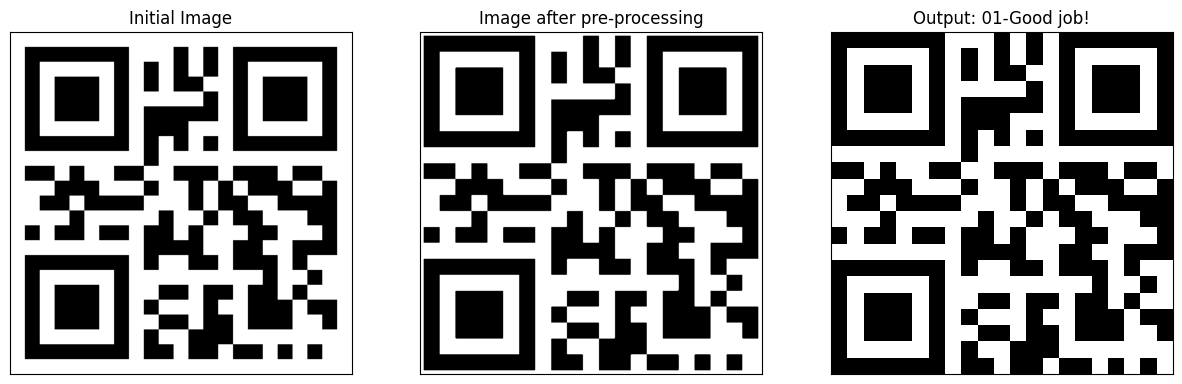

In [16]:
decode(test_cases[0])

'THE MIGHTY FINGER'

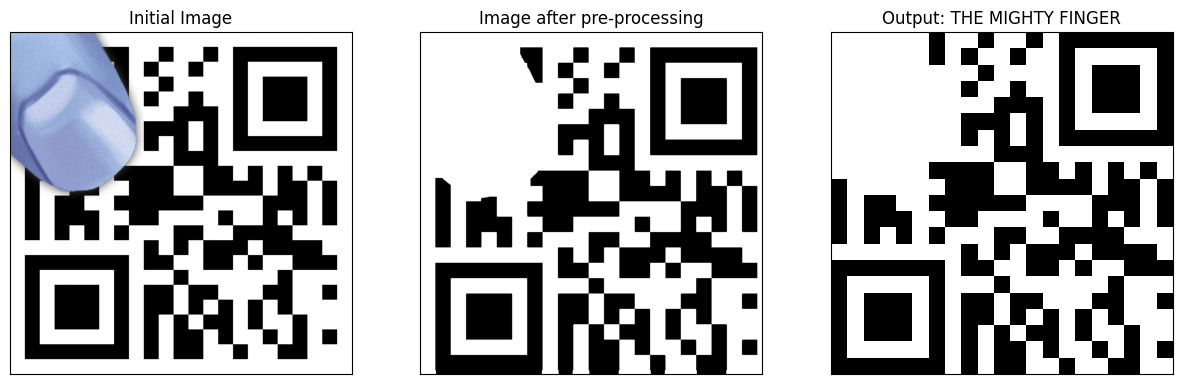

In [17]:
decode(test_cases[1])

"Wow, you did it! Here's your reward: https://youtu.be/dQw4w9WgXcQ"

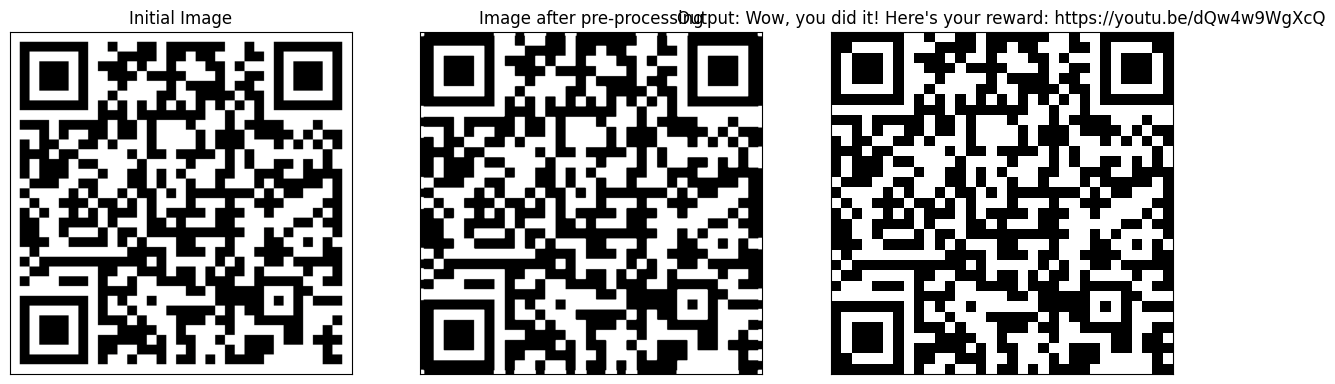

In [18]:
decode(test_cases[2])

'dwXQ49gcwWQ'

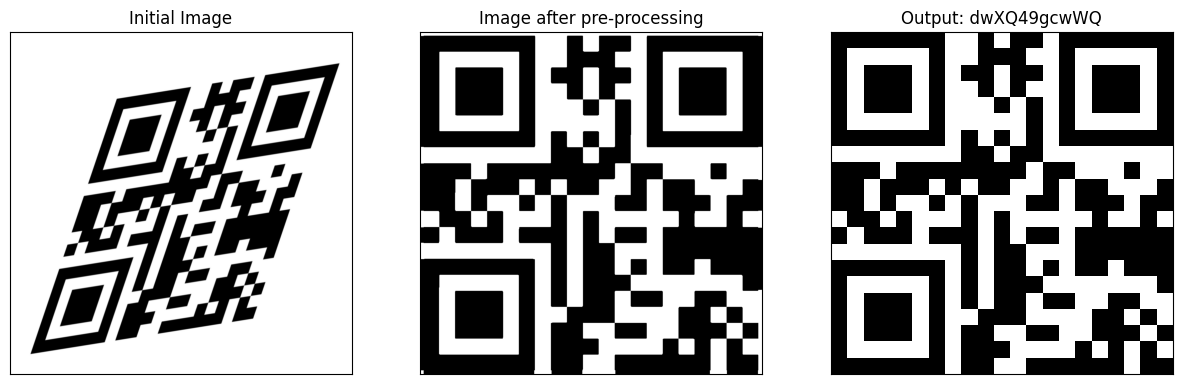

In [19]:
decode(test_cases[3])

'Black mirror hehe'

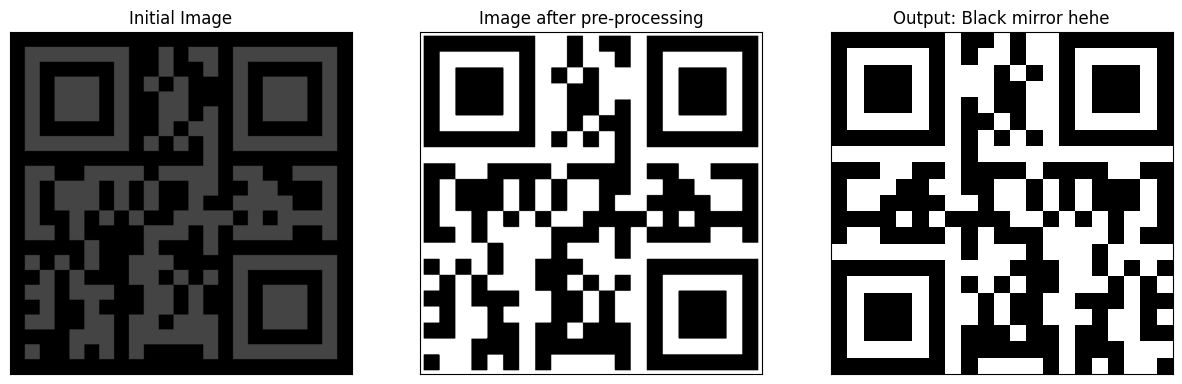

In [20]:
decode(test_cases[4])

'mobiley we23 💀'

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128128 (\N{SKULL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128128 (\N{SKULL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


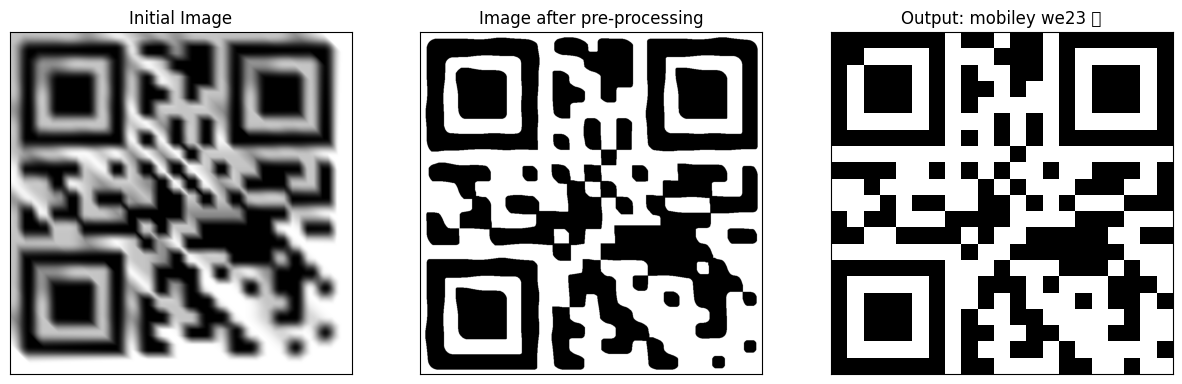

In [21]:
decode(test_cases[5])

'mal7 w felfel'

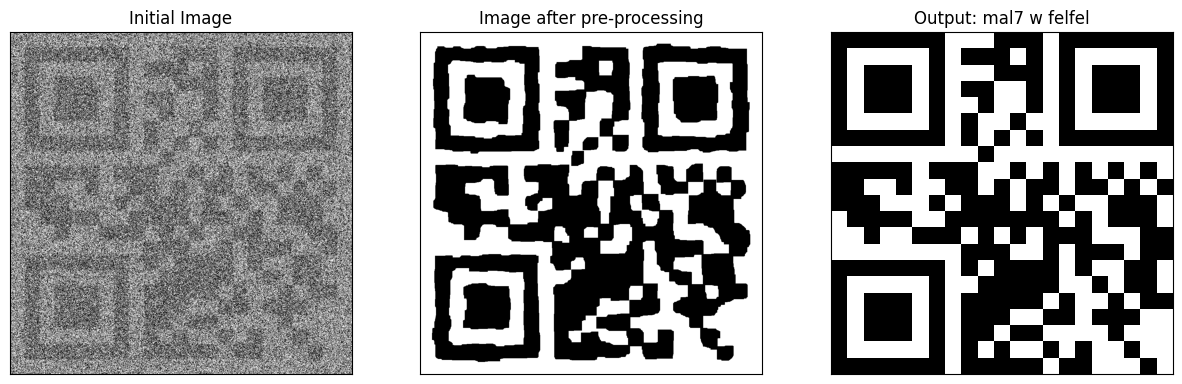

In [22]:
decode(test_cases[6])

'|rxwx1eh2'

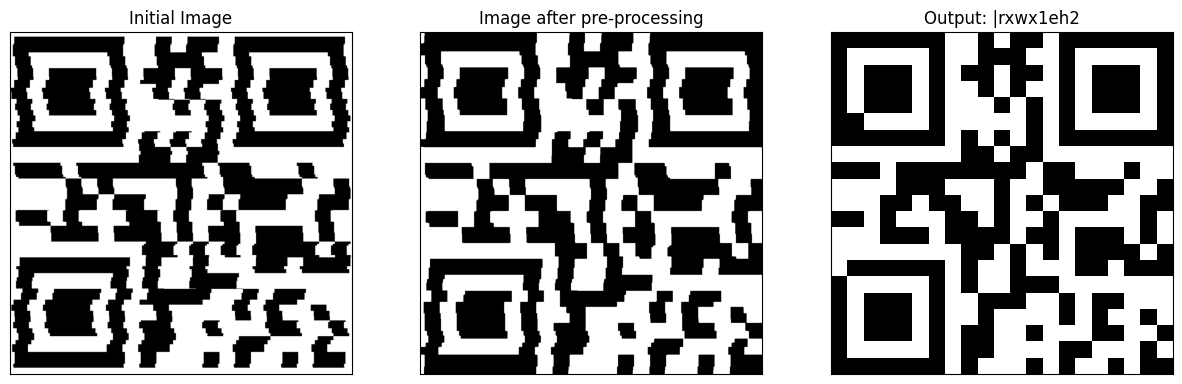

In [23]:
decode(test_cases[7])

'LeffyBinaYaDonya'

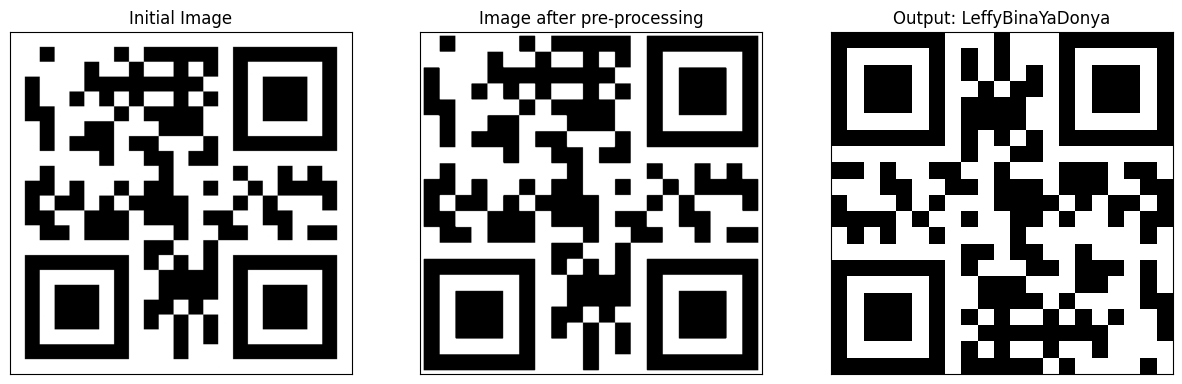

In [24]:
decode(test_cases[8])

'compressoespresso'

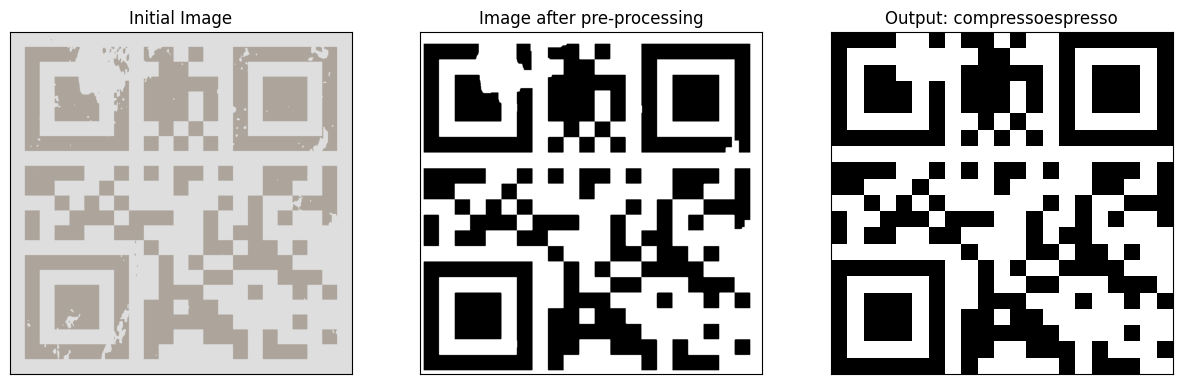

In [25]:
decode(test_cases[9])

'waaaaaves'

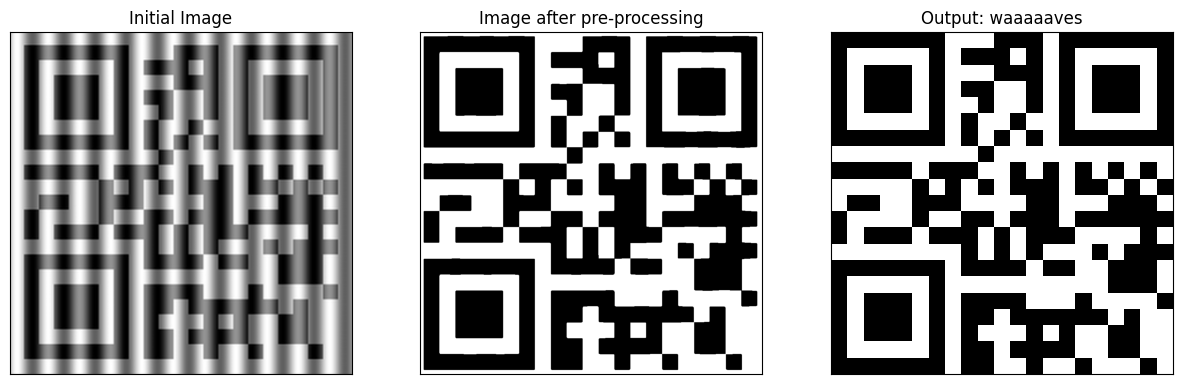

In [26]:
decode(test_cases[10])

'http://en.m.wikipedia.org'

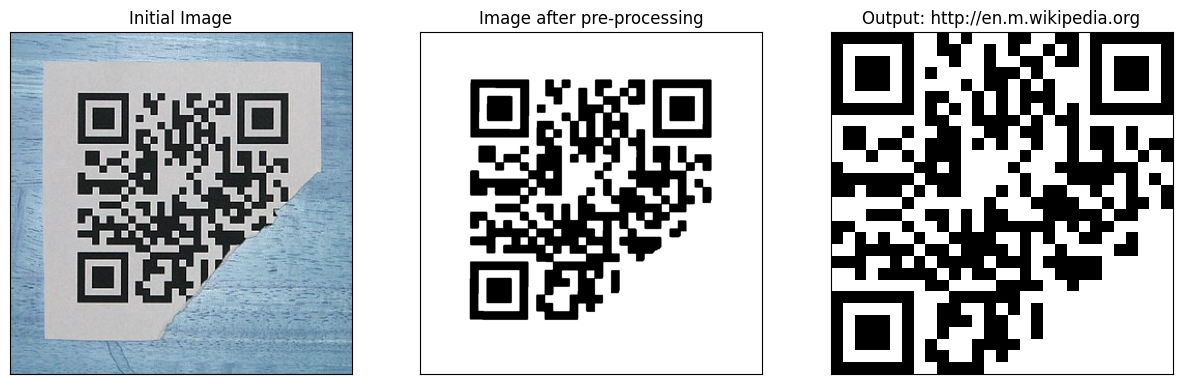

In [27]:
decode(test_cases[11])